Code is taken from https://github.com/karpathy/pytorch-normalizing-flows

In [1]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

import sys; sys.path.append('../../../share/data/')

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nflib.spline_flows import NSF_AR, NSF_CL

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Intro
**Problem:** how to estimate the pdf of final distribution at each point?


**Idea:** Let's define the bijection $z_k=f(z_0)$ between simple distribution of $z_0$ with known pdf and our distribution $z_k$ with unknown pdf


![](https://2.bp.blogspot.com/-g37e2x1miRo/Wl-g8ajU11I/AAAAAAAAHkY/PbIorxOav_Y61yFJeXsQLRlcKTzlkykYwCLcBGAs/s1600/shakir_danilo_slide.png)

**Problem:** ... but known pdf is changed at each point after each transformation $f$

![](https://2.bp.blogspot.com/-1vyL7LpM1io/Wl-ghB0yOiI/AAAAAAAAHkM/_U94kuVeQpk22J5Mg0lbLK-EdMDkaQWggCLcBGAs/s1600/flow1.png)

**Solution:** The Jacobian is exactly the factor how volume is changed at each point $$J_k=|\frac{\partial f_k}{\partial z_k}|$$

### We can stack multiple transformations f

<!-- ![](https://lilianweng.github.io/lil-log/assets/images/normalizing-flow.png) -->

Thus, the final pdf of our distribution can be evaluated as 

$$p(z_k)=\frac{p(z_0)}{\Pi_{i=1}^k J_i}$$

or, 

$$log(p(z_k))=log(p(z_0))-\Sigma_{i=1}^klog(J_i)$$

# Example of transformations
- Planar flows; $f(x) = x + u h(w^\intercal z + b)$
- Radial flows; $f(x) = x + \frac{\beta}{\alpha + |x - x_0|}(x - x_0)$
- Real NVP; affine coupling layer; $f(x^{(2)}) = t(x^{(1)}) + x^{(2)}\odot\exp s(x^{(1)}) $
- Masked Autoregressive Flow (MAF); $f(x_i) = (x_i - \mu(x_{<i})) / \exp(\alpha(x_{<i}))$
- Invertible 1x1 Convolution (Glow);
- ActNorm; $f(x) = Wx + b$ where $W$ is diagonal and $b$ is a constant
- Autoregressive Neural Spline Flow (NSF-AF); $f(x_i) = \mathrm{RQS}_{\theta(x_{<i})}(x_i)$
- Coupling Neural Spline Flow (NSF-CL); $f(x^{(2)}) = \mathrm{RQS}_{\theta(x^{(1)})}(x^{(2)})$

# Example
![](http://akosiorek.github.io/resources/simple_flows.png)

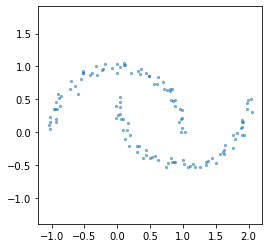

In [4]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetSIGGRAPH:
    """ 
    haha, found from Eric https://blog.evjang.com/2018/01/nf2.html
    https://github.com/ericjang/normalizing-flows-tutorial/blob/master/siggraph.pkl
    """
    def __init__(self):
        with open('siggraph.pkl', 'rb') as f:
            XY = np.array(pickle.load(f), dtype=np.float32)
            XY -= np.mean(XY, axis=0) # center
        self.XY = torch.from_numpy(XY)
    
    def sample(self, n):
        X = self.XY[np.random.randint(self.XY.shape[0], size=n)]
        return X

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

d = DatasetMoons()
# d = DatasetMixture()
#d = DatasetSIGGRAPH()

# sample x using d
x = d.sample(128)

plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [5]:
from nose.tools import assert_equal
assert_equal(x.shape, (128,2))

In [6]:
# construct a model
# prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv) # Logistic distribution

# RealNVP
flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]

# NICE
# flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(4)]
# flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(4)]

# MAF (with MADE net, so we get very fast density estimation)
# flows = [MAF(dim=2, parity=i%2) for i in range(4)]

# IAF (with MADE net, so we get very fast sampling)
# flows = [IAF(dim=2, parity=i%2) for i in range(3)]

# insert ActNorms to any of the flows above
# norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, flows)))

# Glow paper
# flows = [Invertible1x1Conv(dim=2) for i in range(3)]
# norms = [ActNorm(dim=2) for _ in flows]
# couplings = [AffineHalfFlow(dim=2, parity=i%2, nh=32) for i in range(len(flows))]
# flows = list(itertools.chain(*zip(norms, flows, couplings))) # append a coupling layer after each 1x1

# Neural splines, coupling
# nfs_flow = NSF_CL if True else NSF_AR
# flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
# convs = [Invertible1x1Conv(dim=2) for _ in flows]
norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, convs, flows)))
flows = list(itertools.chain(*zip(norms, flows)))

# construct the model
model = NormalizingFlowModel(prior, flows)

In [7]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  22950


In [8]:
model.train()
for k in range(1000):
    # sample x
    x = d.sample(128)
    
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    # define loss = NLL (negative log likelihood)
    loss = -torch.sum(logprob)
    
    # gradient step
    model.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        print(loss.item())


311.0875549316406


231.96067810058594


223.04461669921875


211.76596069335938


186.4010467529297


172.61534118652344


163.32070922851562


150.95831298828125


140.0952606201172


178.75469970703125


In [9]:
assert loss.item() > 0

Text(0.5, 1.0, 'density')

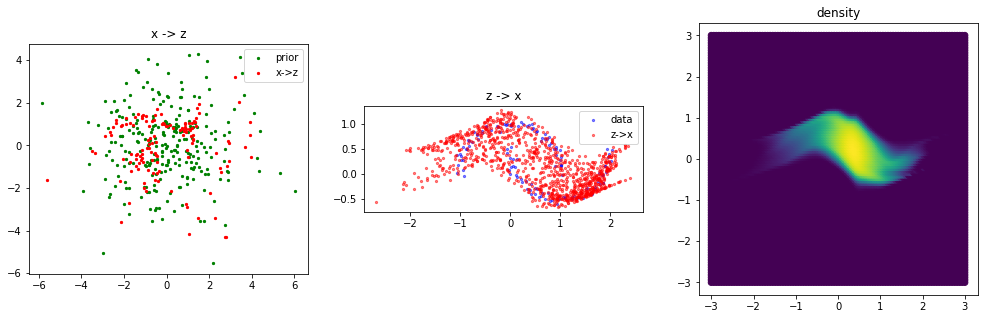

In [10]:
model.eval()

plt.figure(figsize=(17,5))

x = d.sample(128)
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()
plt.subplot(131)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

zs = model.sample(128*8)
z = zs[-1]
z = z.detach().numpy()
plt.subplot(132)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

plt.subplot(133)
ng = 100
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy).float()
zs, prior_logprob, log_det = model(xy)
plt.scatter(xy[:,0], xy[:,1], c=np.nan_to_num(prior_logprob.detach().exp()))
plt.title('density')

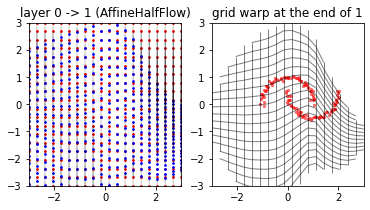

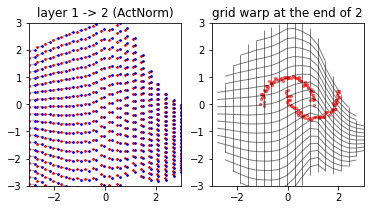

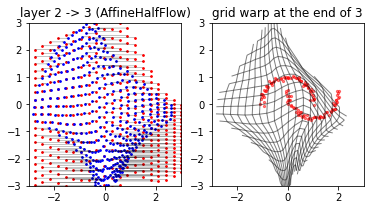

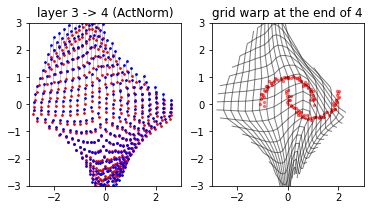

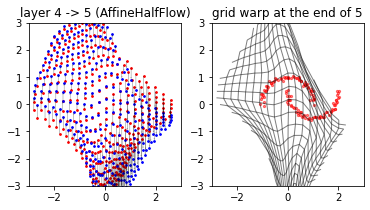

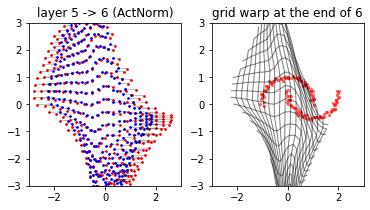

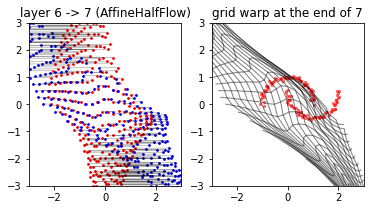

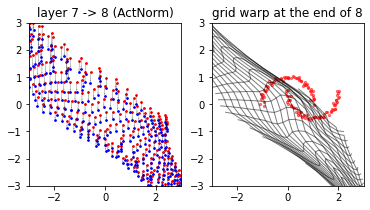

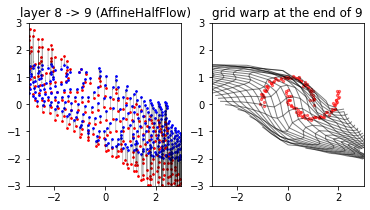

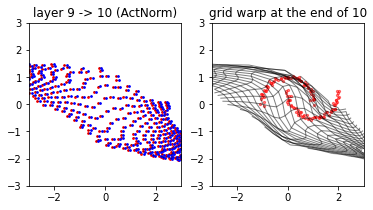

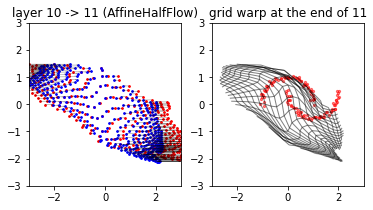

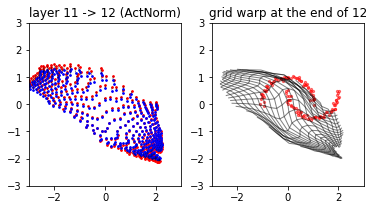

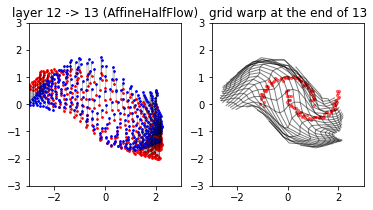

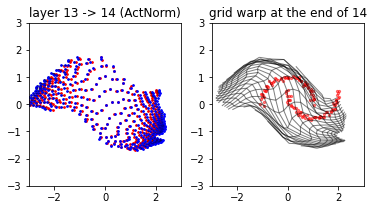

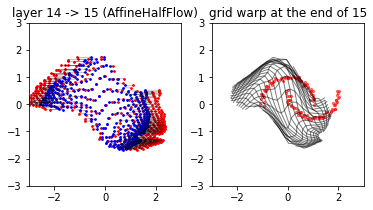

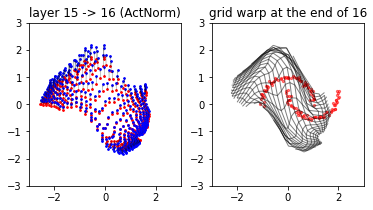

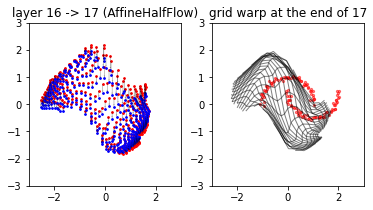

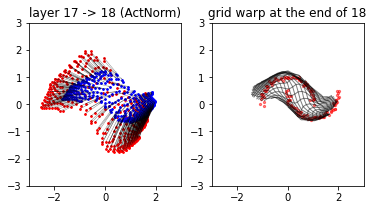

In [11]:
# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

zs, log_det = model.backward(xy)

backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
nz = len(zs)
for i in range(nz - 1):
    z0 = zs[i].detach().numpy()
    z1 = zs[i+1].detach().numpy()
    
    # plot how the samples travel at this stage
    figs, axs = plt.subplots(1, 2, figsize=(6, 3))
    #plt.figure(figsize=(20,10))
    axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=3)
    axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
    axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
    axs[0].axis([-3, 3, -3, 3])
    axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
    
    q = z1.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
    axs[1].axis([-3, 3, -3, 3])
    axs[1].set_title("grid warp at the end of %d" % (i+1,))
    
    # draw the data too
    plt.scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)
    


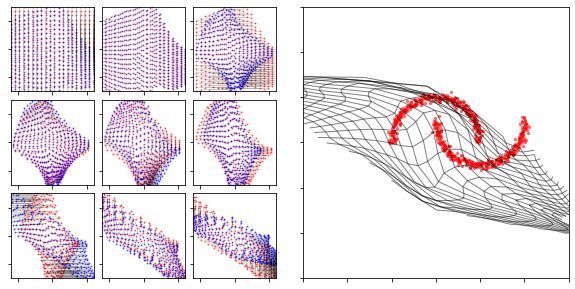

In [12]:

# train and render
# code duplication because it's very late at night now and i'm tired

import matplotlib.gridspec as gridspec

ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

xval = d.sample(128*5)

model.train()
for k in range(500):
    
    # sample
    x = d.sample(128)
    
    # train a bit
    zs, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob) # NLL
    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    if k % 10 == 0:
        # vis
        zs, log_det = model.backward(xy)
        backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
        nz = len(zs)
        i = nz - 1 - 1

        z0 = zs[i].detach().numpy()
        z1 = zs[i+1].detach().numpy()

        # plot how the samples travel at this stage
        ss = 0.1
        fig = plt.figure(figsize=(10, 5))
        outer = gridspec.GridSpec(1, 2, wspace=ss, hspace=ss)
        inner1 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=outer[0], wspace=ss, hspace=ss)
        inner2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], wspace=ss, hspace=ss)
        
        backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
        nz = len(zs)
        for i in range(min(nz-1, 9)):
            ax = plt.Subplot(fig, inner1[i])
            z0 = zs[i].detach().numpy()
            z1 = zs[i+1].detach().numpy()
            ax.scatter(z0[:,0], z0[:, 1], c='r', s=1, alpha=0.5)
            ax.scatter(z1[:,0], z1[:, 1], c='b', s=1, alpha=0.5)
            ax.quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
            ax.axis([-3, 3, -3, 3])
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            #ax.set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
            fig.add_subplot(ax)
        
        ax = plt.Subplot(fig, inner2[0])
        q = z1.reshape((ng, ng, 2))
        # y coords
        p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # x coords
        p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
        p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
        inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
        p1, p2 = p1[inc], p2[inc]
        lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
        # draw the lines
        ax.add_collection(lcy)
        ax.add_collection(lcx)
        ax.axis([-3, 3, -3, 3])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        #ax.set_title("grid warp at the end of %d" % (i+1,))
        fig.add_subplot(ax)
        
        # draw the data too
        plt.scatter(xval[:,0], xval[:,1], c='r', s=5, alpha=0.5)
        
        break
        #fname = 'out/step_%04d.png' % (k,)
        #plt.savefig(fname, dpi=200)
        #print("saved", fname, 'loss', loss.item())
        #plt.close(fig)
        